# cheias.pt — Geographic Assets Explorer

Visual exploration of the two base geographic layers:
- **Districts** (`assets/districts.geojson`) — 18 mainland Portuguese districts with IPMA warning area codes
- **River basins** (`assets/basins.geojson`) — 11 Portuguese river basins from HydroSHEDS level 7

**Date:** 2026-02-11

---

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import folium
import json
import numpy as np

ASSETS = "../assets"

districts = gpd.read_file(f"{ASSETS}/districts.geojson")
basins = gpd.read_file(f"{ASSETS}/basins.geojson")

print(f"Districts: {len(districts)} features, CRS={districts.crs}")
print(f"Basins:    {len(basins)} features, CRS={basins.crs}")

Districts: 18 features, CRS=EPSG:4326
Basins:    11 features, CRS=EPSG:4326


---
## 1. Districts — IPMA Warning Areas

Each district maps to an IPMA `idAreaAviso` code used in the weather warnings API.
These are the spatial units for displaying IPMA precipitation/wind/wave warnings.

In [2]:
# District attribute table
districts.sort_values("idDistrito")[["idDistrito", "ipma_code", "district", "hasc"]].reset_index(drop=True)

,idDistrito,ipma_code,district,hasc
0,1,AVR,Aveiro,PT.AV
1,2,BJA,Beja,PT.BE
2,3,BRG,Braga,PT.BR
3,4,BGC,Bragança,PT.BA
4,5,CBO,Castelo Branco,PT.CB
5,6,CBR,Coimbra,PT.CO
6,7,EVR,Évora,PT.EV
7,8,FAR,Faro,PT.FA
8,9,GDA,Guarda,PT.GU
9,10,LRA,Leiria,PT.LE


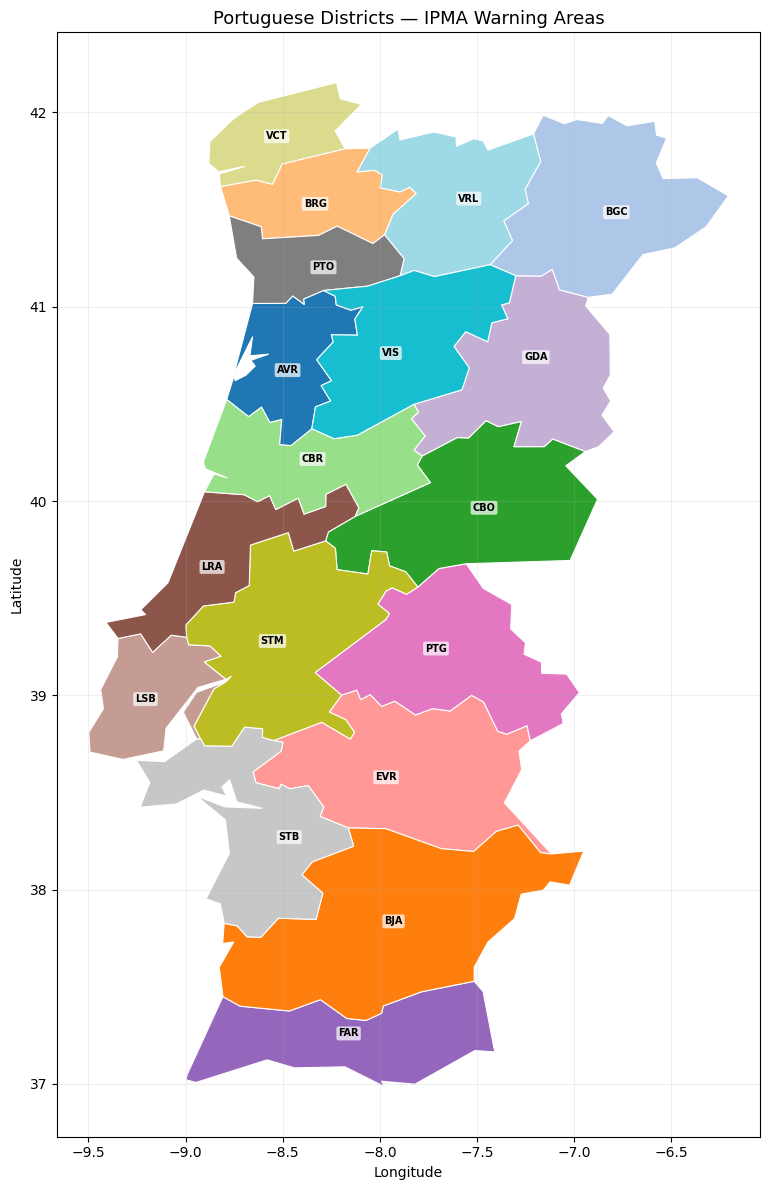

Bounds: [-9.4974666  36.98676179 -6.20594722 42.15362966]
Total area: 88114 km²


In [3]:
fig, ax = plt.subplots(1, 1, figsize=(8, 12))

districts.plot(
    ax=ax,
    column="ipma_code",
    cmap="tab20",
    edgecolor="white",
    linewidth=0.8,
    legend=False,
)

# Label each district with IPMA code
for _, row in districts.iterrows():
    centroid = row.geometry.representative_point()
    ax.annotate(
        row["ipma_code"],
        xy=(centroid.x, centroid.y),
        ha="center", va="center",
        fontsize=7, fontweight="bold",
        color="black",
        bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.7, edgecolor="none"),
    )

ax.set_title("Portuguese Districts — IPMA Warning Areas", fontsize=13)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True, alpha=0.2)
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

print(f"Bounds: {districts.total_bounds}")
print(f"Total area: {districts.to_crs(epsg=3763).area.sum() / 1e6:.0f} km\u00b2")

---
## 2. River Basins — HydroSHEDS Level 7

Derived from HydroSHEDS HydroBASINS level 7, clipped to Portugal's mainland boundary.
Includes the 8 requested basins plus 3 additional coastal/border basins for full coverage.

In [4]:
# Basin attribute table with computed areas
basins_3763 = basins.to_crs(epsg=3763)
basins["area_km2"] = basins_3763.area / 1e6

basins.sort_values("area_km2", ascending=False)[
    ["river", "name_pt", "type", "transboundary", "area_km2"]
].reset_index(drop=True)

,river,name_pt,type,transboundary,area_km2
0,Douro,Douro,major,True,18335.256977
1,Sado,Sado,major,False,15989.058825
2,Tejo,Tejo,major,True,11524.238288
3,Guadiana,Guadiana,major,True,11221.373666
4,Mondego,Mondego,major,False,6798.387003
5,Algarve,Ribeiras do Algarve,coastal,False,6540.966814
6,Minho-Lima,Minho-Lima,major,True,5743.201502
7,Vouga,Vouga,secondary,False,3936.955034
8,Zêzere,Zêzere,tributary,False,3639.040873
9,Oeste,Ribeiras do Oeste,coastal,False,2521.013044


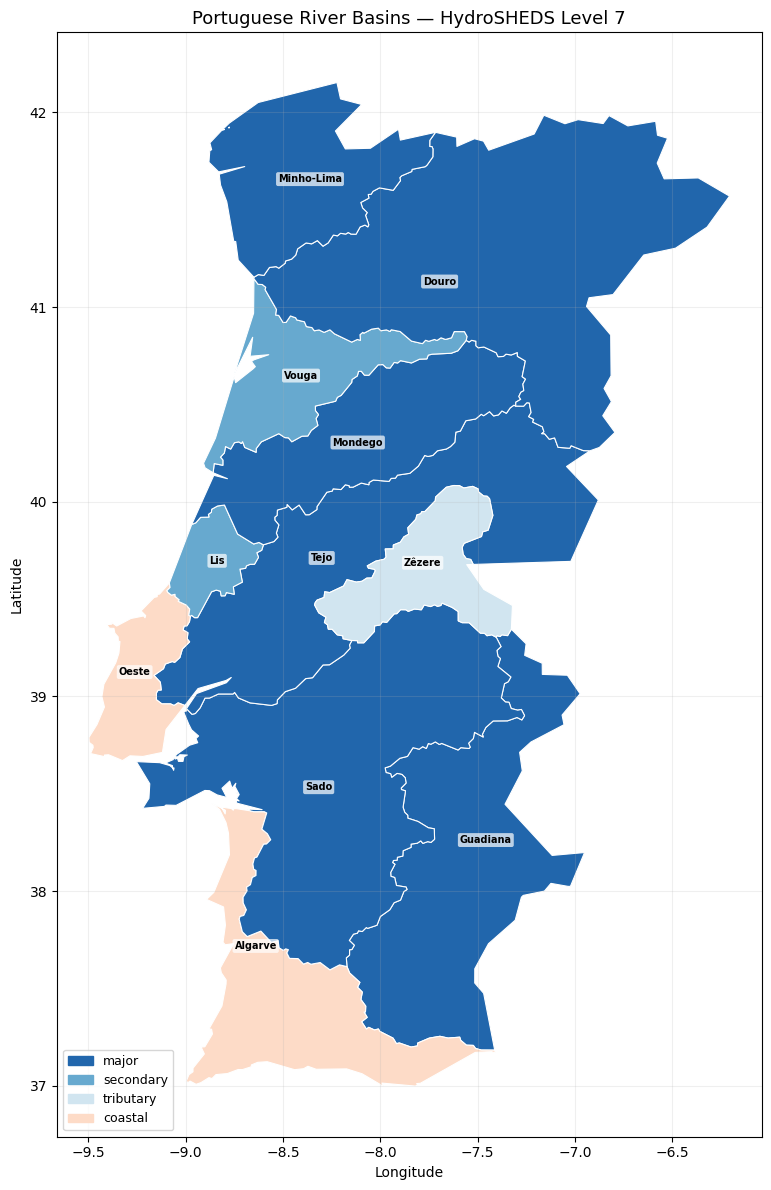

In [5]:
# Color by basin type
type_colors = {
    "major": "#2166ac",
    "secondary": "#67a9cf",
    "tributary": "#d1e5f0",
    "coastal": "#fddbc7",
}
basins["color"] = basins["type"].map(type_colors)

fig, ax = plt.subplots(1, 1, figsize=(8, 12))

basins.plot(
    ax=ax,
    color=basins["color"],
    edgecolor="white",
    linewidth=0.8,
)

# Label each basin
for _, row in basins.iterrows():
    centroid = row.geometry.representative_point()
    label = row["river"]
    ax.annotate(
        label,
        xy=(centroid.x, centroid.y),
        ha="center", va="center",
        fontsize=7, fontweight="bold",
        color="black",
        bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.7, edgecolor="none"),
    )

# Legend
legend_handles = [mpatches.Patch(color=c, label=t) for t, c in type_colors.items()]
ax.legend(handles=legend_handles, loc="lower left", fontsize=9)

ax.set_title("Portuguese River Basins — HydroSHEDS Level 7", fontsize=13)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True, alpha=0.2)
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

---
## 3. Overlay — Districts + Basins

Districts (IPMA warning units) and river basins don't align — a warning for Setubal district
covers parts of both the Sado and Tejo basins. This overlay shows the mismatch that the
platform will need to handle.

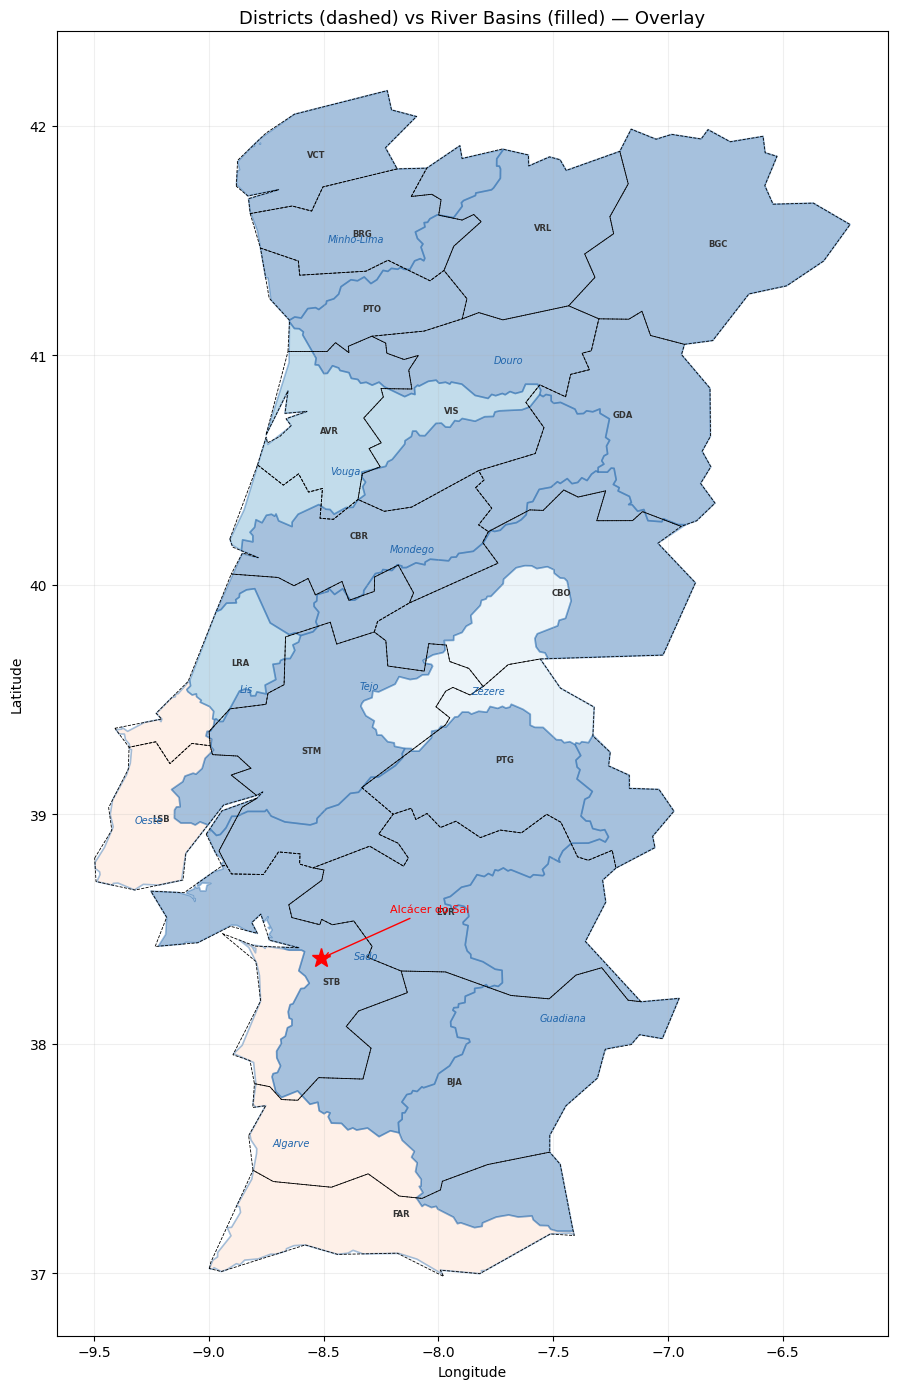

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 14))

# Basins as filled polygons
basins.plot(
    ax=ax,
    color=basins["color"],
    edgecolor="#2166ac",
    linewidth=1.2,
    alpha=0.4,
)

# Districts as outlines only
districts.boundary.plot(
    ax=ax,
    color="black",
    linewidth=0.6,
    linestyle="--",
)

# Label districts
for _, row in districts.iterrows():
    centroid = row.geometry.representative_point()
    ax.annotate(
        row["ipma_code"],
        xy=(centroid.x, centroid.y),
        ha="center", va="center",
        fontsize=6, fontweight="bold", color="#333",
    )

# Label basins
for _, row in basins.iterrows():
    centroid = row.geometry.representative_point()
    ax.annotate(
        row["river"],
        xy=(centroid.x, centroid.y - 0.15),
        ha="center", va="center",
        fontsize=7, fontstyle="italic", color="#2166ac",
    )

# Mark the Alcacer do Sal test point
ax.plot(-8.5103, 38.3728, "r*", markersize=14, zorder=5)
ax.annotate(
    "Alc\u00e1cer do Sal",
    xy=(-8.5103, 38.3728),
    xytext=(-8.5103 + 0.3, 38.3728 + 0.2),
    arrowprops=dict(arrowstyle="->", color="red"),
    fontsize=8, color="red",
)

ax.set_title("Districts (dashed) vs River Basins (filled) — Overlay", fontsize=13)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True, alpha=0.2)
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

---
## 4. Interactive Map — Folium

Interactive Leaflet map with both layers as toggleable overlays.
Click any feature to see its properties.

In [7]:
# Center on Portugal
m = folium.Map(location=[39.5, -8.0], zoom_start=7, tiles="cartodbpositron")

# District layer
district_style = lambda x: {
    "fillColor": "#fee08b",
    "color": "#333",
    "weight": 1.5,
    "fillOpacity": 0.3,
}

districts_layer = folium.GeoJson(
    districts.to_json(),
    name="Districts (IPMA)",
    style_function=district_style,
    tooltip=folium.GeoJsonTooltip(
        fields=["district", "ipma_code", "idDistrito"],
        aliases=["District", "IPMA Code", "ID"],
    ),
)
districts_layer.add_to(m)

# Basin layer with color by type
basin_colors = {
    "major": "#2166ac",
    "secondary": "#67a9cf",
    "tributary": "#92c5de",
    "coastal": "#f4a582",
}

basin_style = lambda x: {
    "fillColor": basin_colors.get(x["properties"].get("type", ""), "#999"),
    "color": "#2166ac",
    "weight": 2,
    "fillOpacity": 0.35,
}

# Need to drop area_km2 (numpy float) for JSON serialization
basins_for_map = basins.drop(columns=["area_km2", "color"], errors="ignore")

basins_layer = folium.GeoJson(
    basins_for_map.to_json(),
    name="River Basins",
    style_function=basin_style,
    tooltip=folium.GeoJsonTooltip(
        fields=["river", "name_pt", "type", "transboundary"],
        aliases=["River", "Nome PT", "Type", "Transboundary"],
    ),
)
basins_layer.add_to(m)

# Test point
folium.Marker(
    [38.3728, -8.5103],
    popup="Alc\u00e1cer do Sal (test location)",
    icon=folium.Icon(color="red", icon="info-sign"),
).add_to(m)

# Layer control
folium.LayerControl().add_to(m)

m

---
## 5. IPMA Warnings Join — Live Warning Map

Fetch current IPMA warnings and join to district boundaries to create a choropleth
showing warning severity per district. This is the core visualization for the MVP.

In [8]:
import requests
import pandas as pd
from datetime import datetime

# Fetch current IPMA warnings
resp = requests.get("https://api.ipma.pt/open-data/forecast/warnings/warnings_www.json")
resp.raise_for_status()
warnings = resp.json()

w_df = pd.DataFrame(warnings)
w_df["startTime"] = pd.to_datetime(w_df["startTime"])
w_df["endTime"] = pd.to_datetime(w_df["endTime"])

# Filter: active now, precipitation only, non-green
now = pd.Timestamp.now()
active = w_df[
    (w_df["startTime"] <= now)
    & (w_df["endTime"] >= now)
    & (w_df["awarenessTypeName"] == "Precipita\u00e7\u00e3o")
    & (w_df["awarenessLevelID"] != "green")
]

print(f"Active precipitation warnings (non-green): {len(active)}")

# Get max severity per district
severity_order = {"yellow": 1, "orange": 2, "red": 3}
active = active.copy()
active["severity"] = active["awarenessLevelID"].map(severity_order)

max_severity = active.groupby("idAreaAviso")["severity"].max().reset_index()
max_severity.columns = ["ipma_code", "severity"]

# Join to districts
districts_warn = districts.merge(max_severity, on="ipma_code", how="left")
districts_warn["severity"] = districts_warn["severity"].fillna(0).astype(int)

# Map severity to colors and labels
severity_colors = {0: "#e0e0e0", 1: "#fee08b", 2: "#fdae61", 3: "#d73027"}
severity_labels = {0: "None", 1: "Yellow", 2: "Orange", 3: "Red"}
districts_warn["warn_color"] = districts_warn["severity"].map(severity_colors)
districts_warn["warn_label"] = districts_warn["severity"].map(severity_labels)

for _, row in districts_warn.sort_values("severity", ascending=False).iterrows():
    if row["severity"] > 0:
        print(f"  {row['ipma_code']} {row['district']:20s} {row['warn_label']}")

Active precipitation warnings (non-green): 0


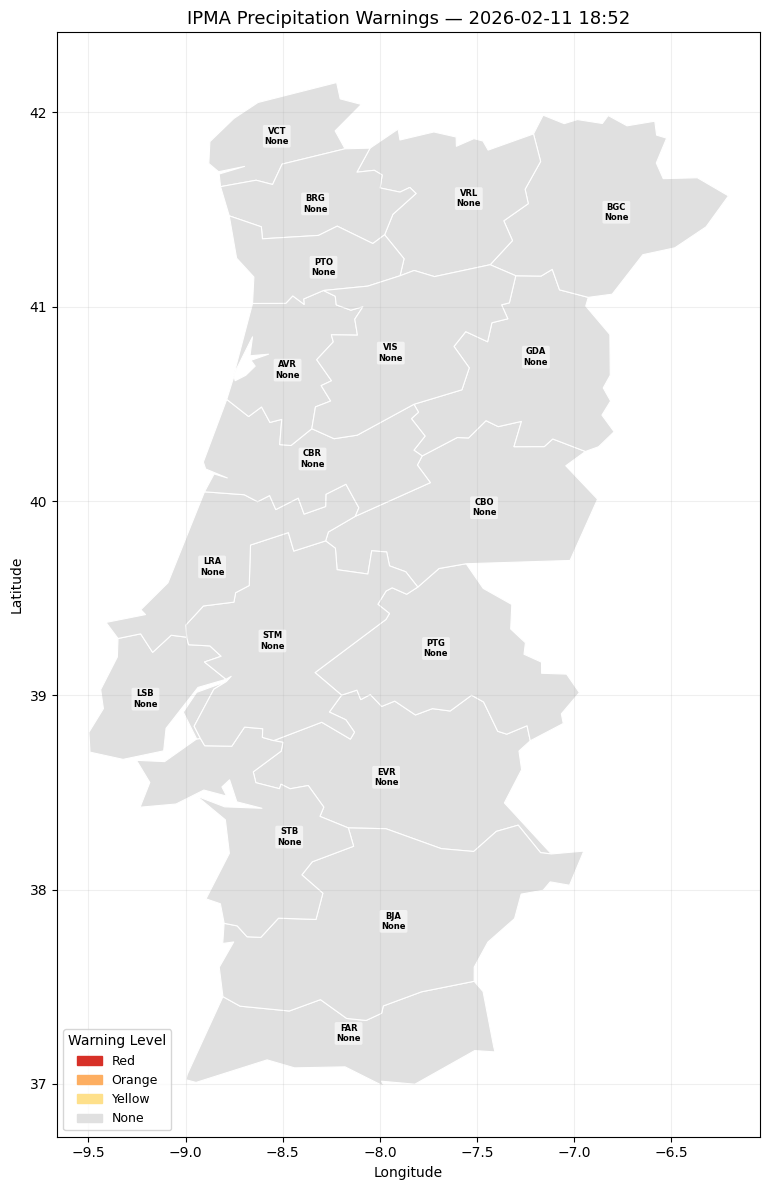

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 12))

districts_warn.plot(
    ax=ax,
    color=districts_warn["warn_color"],
    edgecolor="white",
    linewidth=0.8,
)

# Label each district
for _, row in districts_warn.iterrows():
    centroid = row.geometry.representative_point()
    ax.annotate(
        f"{row['ipma_code']}\n{row['warn_label']}",
        xy=(centroid.x, centroid.y),
        ha="center", va="center",
        fontsize=6, fontweight="bold",
        bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.6, edgecolor="none"),
    )

# Legend
legend_handles = [
    mpatches.Patch(color=severity_colors[k], label=severity_labels[k])
    for k in [3, 2, 1, 0]
]
ax.legend(handles=legend_handles, loc="lower left", title="Warning Level", fontsize=9)

ax.set_title(f"IPMA Precipitation Warnings — {now.strftime('%Y-%m-%d %H:%M')}", fontsize=13)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True, alpha=0.2)
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

---
## 6. Basin Area Chart + GloFAS Coverage Check

Verify basin sizes make hydrological sense and check which basins have GloFAS
river discharge data via the Open-Meteo Flood API.

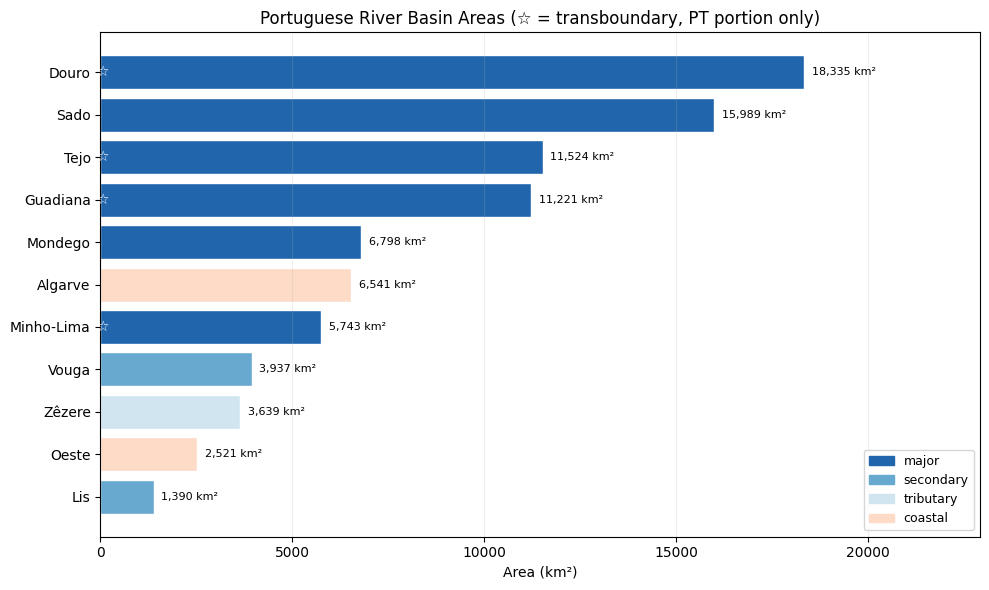

Total mainland area: 87,639 km²
Reference (Wikipedia): ~89,102 km²


In [10]:
# Basin areas horizontal bar chart
basins_sorted = basins.sort_values("area_km2", ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))

colors = [type_colors.get(t, "#999") for t in basins_sorted["type"]]
bars = ax.barh(basins_sorted["river"], basins_sorted["area_km2"], color=colors, edgecolor="white")

# Add area labels
for bar, area in zip(bars, basins_sorted["area_km2"]):
    ax.text(
        bar.get_width() + 200, bar.get_y() + bar.get_height() / 2,
        f"{area:,.0f} km\u00b2",
        va="center", fontsize=8,
    )

# Mark transboundary basins
for i, (_, row) in enumerate(basins_sorted.iterrows()):
    if row.get("transboundary"):
        ax.text(
            50, i, "\u2606",
            va="center", ha="center", fontsize=10, color="white",
        )

legend_handles = [mpatches.Patch(color=c, label=t) for t, c in type_colors.items()]
ax.legend(handles=legend_handles, loc="lower right", fontsize=9)

ax.set_xlabel("Area (km\u00b2)")
ax.set_title("Portuguese River Basin Areas (\u2606 = transboundary, PT portion only)")
ax.set_xlim(0, basins["area_km2"].max() * 1.25)
ax.grid(True, alpha=0.2, axis="x")
plt.tight_layout()
plt.show()

print(f"Total mainland area: {basins['area_km2'].sum():,.0f} km\u00b2")
print(f"Reference (Wikipedia): ~89,102 km\u00b2")

In [11]:
# GloFAS coverage check: query Open-Meteo Flood API at each basin centroid

print("Checking GloFAS river discharge at basin centroids...\n")
print(f"{'Basin':15s} {'Lat':>7s} {'Lon':>7s} {'Discharge':>12s} {'Status'}")
print("-" * 55)

glofas_results = []
for _, row in basins.iterrows():
    centroid = row.geometry.representative_point()
    lat, lon = centroid.y, centroid.x

    try:
        resp = requests.get(
            "https://flood-api.open-meteo.com/v1/flood",
            params={
                "latitude": round(lat, 3),
                "longitude": round(lon, 3),
                "daily": "river_discharge",
                "forecast_days": 3,
            },
            timeout=10,
        )
        resp.raise_for_status()
        data = resp.json()
        discharge = data["daily"]["river_discharge"]
        latest = [v for v in discharge if v is not None]
        if latest:
            q = latest[-1]
            status = f"{q:.1f} m\u00b3/s"
            glofas_results.append({"river": row["river"], "has_data": True, "discharge": q})
        else:
            status = "No data (null)"
            glofas_results.append({"river": row["river"], "has_data": False, "discharge": 0})
    except Exception as e:
        status = f"Error: {e}"
        glofas_results.append({"river": row["river"], "has_data": False, "discharge": 0})

    print(f"{row['river']:15s} {lat:7.3f} {lon:7.3f} {status:>12s}")

covered = sum(1 for r in glofas_results if r["has_data"])
print(f"\nGloFAS coverage: {covered}/{len(glofas_results)} basins")

Checking GloFAS river discharge at basin centroids...

Basin               Lat     Lon    Discharge Status
-------------------------------------------------------


Guadiana         38.263  -7.458  1852.5 m³/s


Algarve          37.719  -8.640     0.8 m³/s


Sado             38.534  -8.316     8.5 m³/s


Tejo             39.711  -8.301     4.4 m³/s


Zêzere           39.687  -7.782     2.5 m³/s


Oeste            39.125  -9.261     7.6 m³/s


Lis              39.697  -8.838    21.6 m³/s


Mondego          40.305  -8.116     6.1 m³/s


Vouga            40.648  -8.407    61.7 m³/s


Douro            41.132  -7.695    15.9 m³/s


Minho-Lima       41.657  -8.361     6.5 m³/s

GloFAS coverage: 11/11 basins


---
## 7. Point-in-Basin Lookup

Given a coordinate, identify which district and basin it belongs to.
This is the spatial join the backend will need to route data to the right layers.

In [12]:
from shapely.geometry import Point

def lookup_location(lat, lon, name=""):
    """Find which district and basin a point falls in."""
    pt = gpd.GeoDataFrame(
        [{"geometry": Point(lon, lat), "name": name}],
        crs="EPSG:4326",
    )

    d = gpd.sjoin(pt, districts, how="left", predicate="within")
    b = gpd.sjoin(pt, basins.drop(columns=["area_km2", "color"], errors="ignore"), how="left", predicate="within")

    district = d.iloc[0].get("district", "Unknown") if len(d) else "Unknown"
    ipma = d.iloc[0].get("ipma_code", "?") if len(d) else "?"
    river = b.iloc[0].get("river", "Unknown") if len(b) else "Unknown"

    print(f"{name or f'{lat}, {lon}'}:")
    print(f"  District: {district} (IPMA: {ipma})")
    print(f"  Basin:    {river}")
    return district, ipma, river


# Test with key locations
test_points = [
    (38.3728, -8.5103, "Alc\u00e1cer do Sal"),
    (38.7223, -9.1393, "Lisboa"),
    (41.1496, -8.6110, "Porto"),
    (40.2033, -8.4103, "Coimbra"),
    (37.0194, -7.9304, "Faro"),
    (39.7436, -8.8071, "Leiria"),
    (40.6405, -8.6538, "Aveiro"),
    (41.8039, -6.7570, "Bragan\u00e7a"),
]

for lat, lon, name in test_points:
    lookup_location(lat, lon, name)
    print()

Alcácer do Sal:
  District: Setúbal (IPMA: STB)
  Basin:    Sado

Lisboa:
  District: Lisboa (IPMA: LSB)
  Basin:    Oeste

Porto:
  District: Porto (IPMA: PTO)
  Basin:    Douro

Coimbra:
  District: Coimbra (IPMA: CBR)
  Basin:    Mondego

Faro:
  District: Faro (IPMA: FAR)
  Basin:    Algarve

Leiria:
  District: Leiria (IPMA: LRA)
  Basin:    Lis

Aveiro:
  District: Aveiro (IPMA: AVR)
  Basin:    Vouga

Bragança:
  District: Bragança (IPMA: BGC)
  Basin:    Douro



---
## Summary

Both geographic layers are valid and ready for the MVP backend:

| Asset | Features | Size | Key Properties |
|-------|----------|------|----------------|
| `districts.geojson` | 18 | 27 KB | `district`, `ipma_code`, `idDistrito` |
| `basins.geojson` | 11 | 64 KB | `river`, `name_pt`, `type`, `transboundary` |

**Key findings:**
- District and basin boundaries don't align — a spatial join is needed to map IPMA warnings to basins
- Transboundary basins (Douro, Tejo, Guadiana, Minho-Lima) show only the Portuguese portion
- GloFAS has data for major basins but may miss smaller coastal basins
- Point-in-polygon lookup works for routing any coordinate to its district + basin